In [1]:
import os
import numpy as np
import pandas as pd
import time
import scanpy as sc
import torch

import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(level=logging.INFO)

import sys
sys.path.append('../../')
import scDualGN
sys.path.append('../')
import expri_helper

/jdfssz1/ST_HEALTH/P18Z10200N0124/AI/user/baiyong/anaconda3/envs/mytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dat_path = expri_helper.get_path('Kazer', dat_ls_file='../expri_data.json')

In [3]:
dat_path

'/tfs11/ST_MCHRI_BIGDATA/zhouruilong/data/scDualGN_yb/clustering_data/Kazer.h5ad'

In [4]:
adata = sc.read_h5ad(dat_path)

In [5]:
sc.pp.filter_cells(adata, min_counts=100)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.highly_variable_genes(adata, n_top_genes=2500)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

In [6]:
lr, alpha, gamma, nu = 0.01, 0.01, 4, 0.01
# acc 0.7849, nmi 0.6928, ari 0.7322, hs 0.6616, cs 0.7271, purity: 0.8335
print('=====================================')
print('lr:{}, alpha:{}, gamma:{}, nu:{}'.format(lr, alpha, gamma, nu))
start = time.time()
torch.cuda.empty_cache()
scdualgn_model = scDualGN.scDualGN(adata, n_z=32,device='cuda:1', batch_size=1024*2, verbosity=True, lr=lr).pretrain(alpha=alpha, beta=1, gamma=gamma)
scdualgn_model.cluster(n_cluster=8, eta=1, nu=nu, n_epochs=64) # n_epochs=30

end = time.time()
print('running time = {}'.format(end-start))



INFO:scDualGN.run:dual-VAE pretrain start...


lr:0.01, alpha:0.01, gamma:4, nu:0.01


INFO:scDualGN.run:Epoch 1/50,Overall loss:2214.2542,MSE:1842.9073,MSE1:92.0248,KL: 324.7645
INFO:scDualGN.run:Epoch 2/50,Overall loss:1572.2075,MSE:1566.6473,MSE1:0.0935,KL: 518.6220
INFO:scDualGN.run:Epoch 3/50,Overall loss:1562.1192,MSE:1557.1450,MSE1:0.0912,KL: 460.9353
INFO:scDualGN.run:Epoch 4/50,Overall loss:1557.1015,MSE:1552.7310,MSE1:0.0971,KL: 398.2115
INFO:scDualGN.run:Epoch 5/50,Overall loss:1551.4941,MSE:1547.5602,MSE1:0.1048,KL: 351.4568
INFO:scDualGN.run:Epoch 6/50,Overall loss:1546.0532,MSE:1542.4205,MSE1:0.1143,KL: 317.5666
INFO:scDualGN.run:Epoch 7/50,Overall loss:1541.6999,MSE:1538.2728,MSE1:0.1179,KL: 295.5452
INFO:scDualGN.run:Epoch 8/50,Overall loss:1538.7331,MSE:1535.4337,MSE1:0.1203,KL: 281.7981
INFO:scDualGN.run:Epoch 9/50,Overall loss:1536.5075,MSE:1533.2780,MSE1:0.1212,KL: 274.4849
INFO:scDualGN.run:Epoch 10/50,Overall loss:1535.2290,MSE:1532.0280,MSE1:0.1202,KL: 272.0171
INFO:scDualGN.run:Epoch 11/50,Overall loss:1547.4279,MSE:1544.4236,MSE1:0.1268,KL: 249.7

acc 0.7849, nmi 0.6928, ari 0.7322, hs 0.6616, cs 0.7271, purity: 0.8335
running time = 407.0425615310669


In [7]:
adata.obs['celltype_scDualGN']=scdualgn_model.y_pred_label
adata.obs['celltype_scDualGN'] = adata.obs['celltype_scDualGN'].astype('category')
adata.obsm['X_z']=scdualgn_model.z

sc.pp.neighbors(adata,n_neighbors=20,use_rep="X_z") 
sc.tl.umap(adata)

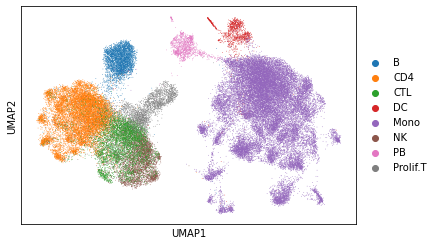

In [8]:
sc.pl.umap(adata, color=['celltype_str'],title='')

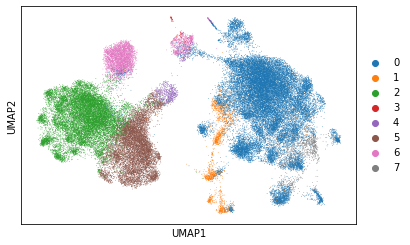

In [9]:
sc.pl.umap(adata, color=['celltype_scDualGN'],title='')

In [10]:
adata.obs['celltype'].value_counts()

4    29131
1    12010
5     5067
2     4343
0     3649
7     2544
3     1339
6     1203
Name: celltype, dtype: int64

In [11]:

values, counts = np.unique(scdualgn_model.y_pred_label, return_counts=True)

In [12]:
values

array([0, 1, 2, 3, 4, 5, 6, 7])

In [13]:
counts

array([28101,  1825, 14549,   104,   671,  9075,  3878,  1083])